# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Вторая лабораторная работа </center>
# <center> Анализ сигналов </center>

In [2]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise') 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Определим две функции для отрисовки сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    #librosa.display.waveplot(wav, sr=sr)
    librosa.display.waveshow(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()
    

Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования

In [4]:
signals = {}

### Единичный импульс

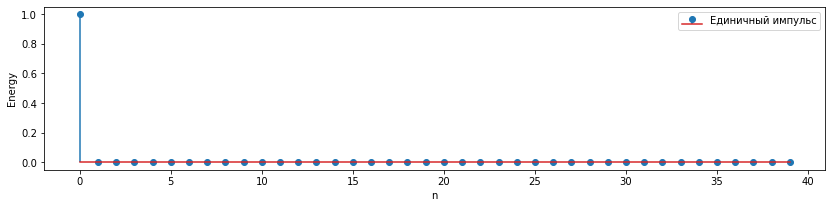

In [5]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

### Единичный скачок

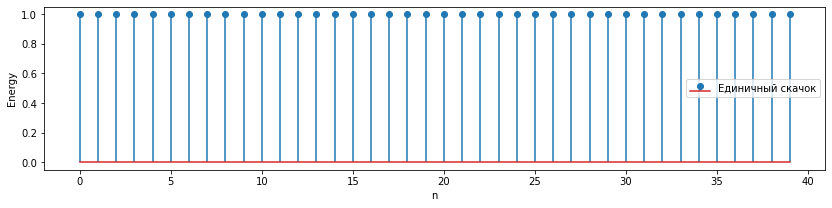

In [6]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float) 
draw_sig(signals[name], name)

### Синус

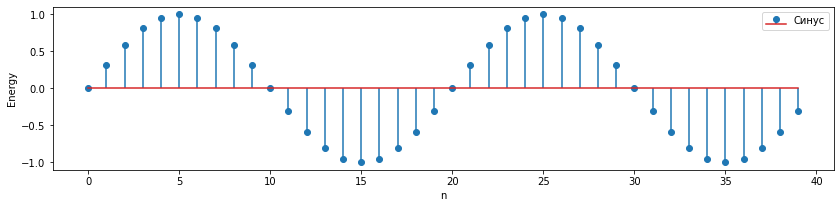

In [7]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

### Шум

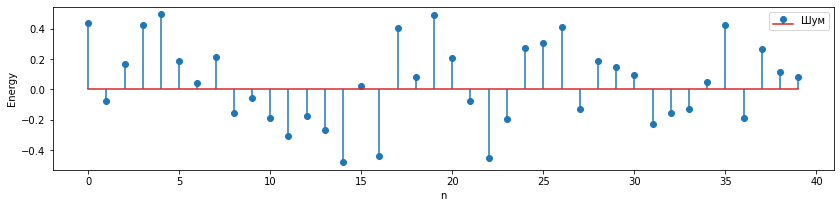

In [8]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье. 
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT):
$$ X_k = \sum_{n=0}^{N-1} x_{n} \cdot e^{-i \frac{2\pi}{N} k n} $$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией *scipy.fft.fft*

In [9]:
def DFT(x):
    # YOUR CODE HERE
    
    n = len(x)
    ansver = np.array([], 'complex')

    for k in range(len(x)):
        ans_k = 0
        
        for i in range(n):
            ans_k += x[i]*np.exp(-2j * np.pi *k*i /n)
        
        ansver = np.append(ansver, ans_k) 
    
    return ansver
    

Сравнение с библиотекой scipy

In [10]:
def test_DTF(x, transform=DFT):
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях. 

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

**Подсказка:** учтите, что для БПФ нам нужно, чтобы количество отсчетов сигнала было степенью двойки

In [11]:
def FFT(x):
    # YOUR CODE HERE
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("size error")
    elif N <= 32:
        return DFT(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        
        return np.concatenate([X_even + factor[:int(N / 2)] * X_odd,
                               X_even + factor[int(N / 2):] * X_odd])
    
    
    

In [12]:
for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig, transform=FFT) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости. 
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [13]:
#функция построения амплитудного спектра
def get_amplitude_from_spec(spec):
    # YOUR CODE HERE
    return np.abs(spec)


#функция построения фазового спектра
def get_phi_from_spec(spec):
    # YOUR CODE HERE
    return np.angle(spec)

In [14]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong Amplitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong Phase"

    
_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  Amplitude"
assert get_amplitude_from_spec(_spec)[0] == 10, \
    "Wrong Amplitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_amplitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong Amplitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong Amplitude. Make sure it is an angle."

   
print("All OK!")

All OK!


Определим еще одну функцию для отрисовки. Теперь будем рисовать сигнал в частотной области

In [15]:
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Amplitude spectrum")
        spec_A = get_amplitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
<!-- 1. Почему амплитуда всех гармоник единичного импульса равна единице? 
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый? 
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему? -->

### Визуализация:

In [16]:
# YOUR CODE HERE
spectrum_impuls = FFT(signals['Единичный импульс'])
spectrum_jump = FFT(signals['Единичный скачок'])
spectrum_sin = FFT(signals['Синус'])
spectrum_noise = FFT(signals['Шум'])


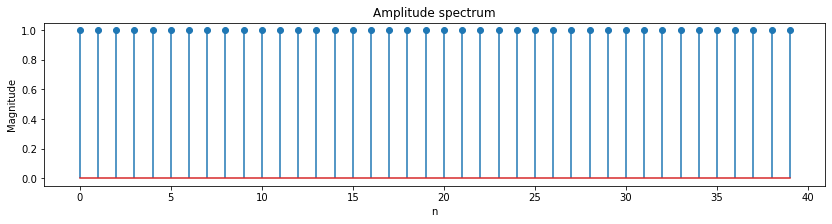

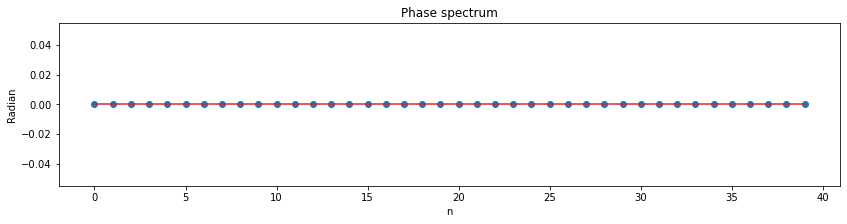

In [17]:
draw_spec(spectrum_impuls)

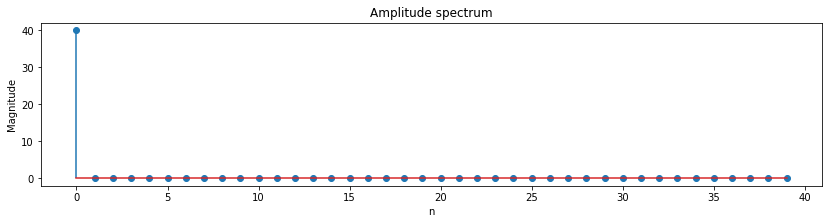

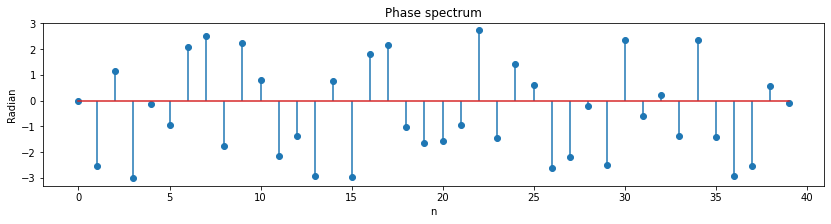

In [18]:
draw_spec(spectrum_jump)

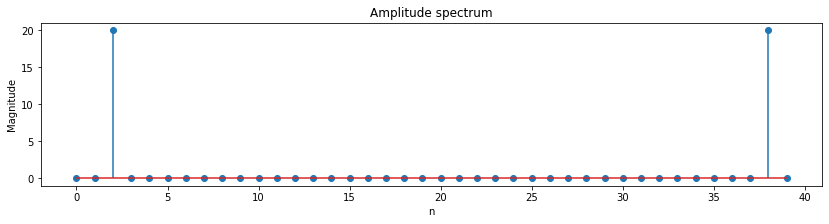

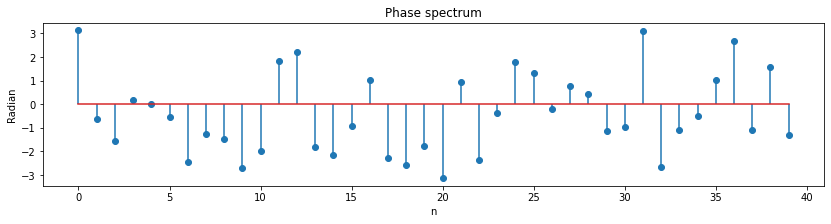

In [19]:
draw_spec(spectrum_sin)

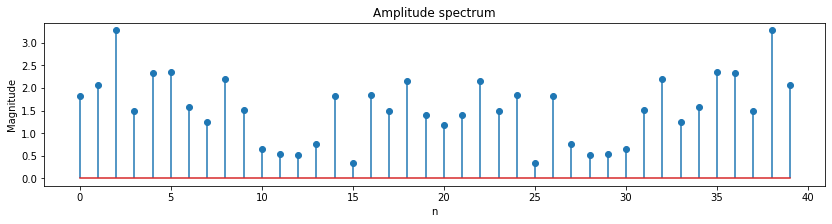

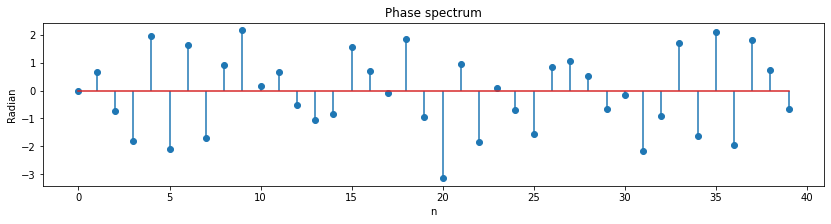

In [20]:
draw_spec(spectrum_noise)

### 1.Почему амплитуда всех гармоник единичного импульса равна константе?

Тут если применить преобразование Фурье по формуле анализа для единичного импульса получаем что x(n) равняется нулу везде, кроме нулевого отсчета (а в нуле 1) Экспаненциальная же часть равняется 1. поэтому видим, что для каждой гармоники k будет равна константе(единице)

### 2. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый?

По амплитудному спектру можно сделать вывод о всех частотных составляющих сигнала (увидеть и отделить несущую частоту если это радио-сигнал, подавить или обрезать шум и много других интересных вещей).
В фазовом спектре же можно сделать вывод о состоянии начальных фаз частот. 


### 3. Как перевести номер отсчета в частоту?

Существует формула, связвывающая эти параметры
$$\large
f_k = \frac{f_д}{N} \cdot k
$$

где k -номер осчета

$f_д$ - частота дискретизации

а результат будет в герцах


### 4. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

Возможно полезной информацией являются начальные фазы частот сигнала, а шумом - начальные фазы шумовых составляющих

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье (Short-time Fourier transform), пользуясь только библиотеками *numpy* и *scipy*. Сравнить с *librosa.stft*


In [22]:
def DFT(x):
    # YOUR CODE HERE
    
    n = len(x)
    ansver = np.array([], 'complex')

    for k in range(len(x)):
        ans_k = 0
        
        for i in range(n):
            ans_k += x[i]*np.exp(-2j * np.pi *k*i /n)
        
        ansver = np.append(ansver, ans_k) 
    
    return ansver



In [23]:
'''Функция разделяющая сингал на окна заданого размера с заданым шагом'''
def get_windows_array(x, n_fft, hop_length):
    #x - signal
    # n_fft - fft window size 
    # hop_length - step size between ffts
    windows = np.empty((0,n_fft))
    steps_num = int(len(x) / hop_length)
    for i in range(steps_num):
        if(len(x[i*hop_length: i*hop_length+n_fft]) != n_fft):
            continue      
        windows = np.append(windows, np.array([x[i*hop_length: i*hop_length+n_fft]]), axis=0)
        
        
    return windows;

In [24]:
def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    # x - signal
    # n_fft - fft window size 
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    # return spectrogram 
    
    # YOUR CODE HERE

    
    # паддинг сигнала, так как в тесте он включен по умолчанию 
    padding = [(0, 0) for _ in range(x.ndim)]
    padding[-1] = (int(n_fft // 2), int(n_fft // 2))
    x = np.pad(x, padding)
    
    #разделённый на нужные участки сигнал
    windowed_signal = get_windows_array(x, n_fft, hop_length)
    
    # окошко-маска
    fft_window = scipy.signal.get_window(window, n_fft, fftbins=True)
    #fft_window = scipy.signal.windows.hann(n_fft)
    
    # Получаем сигнал умноженый на окошки нужной формы, а не просто прямоугольные
    for i in range(len(windowed_signal)):
        windowed_signal[i] = windowed_signal[i]*fft_window
        
    
    spectrogram = np.empty((len(windowed_signal), int(1 + n_fft // 2)), dtype=np.complex)

    
    for i in range(len(windowed_signal)):
        jojo = np.fft.rfft(windowed_signal[i])    
        spectrogram[i] = jojo
        
    return spectrogram.T
        

In [25]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1 
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0
        
for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
ok
Checking 'Единичный скачок'
ok
Checking 'Синус'
ok
Checking 'Шум'
ok
All ok!


Определим функцию для отрисовки

In [26]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма 
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты. 


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Загрузим аудио файл с паровозным гудком

Len is 82175 ( ). Sample rate is 22050


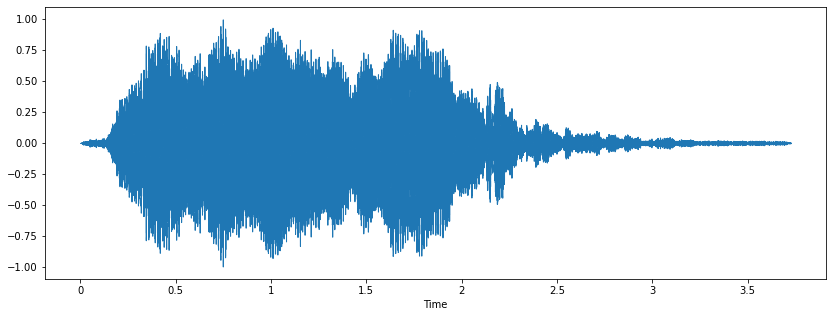

In [27]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("resources/train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Построим гудок паровоза в частотной области

Гудок паровоза в частотной области


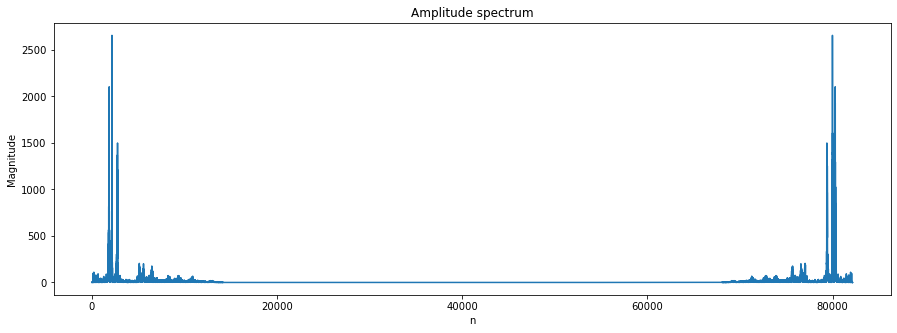

In [121]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


Амплитудный спектр

рассмотрим подробно первые 4000 отсчетов в них судя по всему и видно эти гармоники

In [122]:
train_whistle_spec_part = train_whistle_spec[:3000]

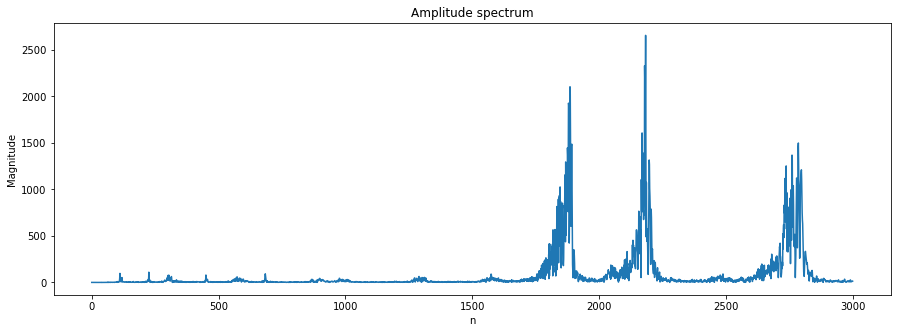

In [123]:
draw_spec(train_whistle_spec_part, draw_p=False, figsize=(15,5))

In [124]:
k1 = np.argmax(train_whistle_spec[1500:2000])
k1 = k1 + 1500
k1

1885

In [125]:
k2 = np.argmax(train_whistle_spec[2000:2500])
k2 = k2 + 2000
k2

2183

In [126]:
k3 = np.argmax(train_whistle_spec[2500:2990])
k3 = k3 + 2500
k3

2779

отсчеты пересчитываются в частоту по формуле
$$
f_k = \frac{f_д}{N} \cdot k
$$

Итого максимумы гармоник находятся прибоизительно на 1890 2190 и 2790 


### 1 гармоника

In [127]:
# YOUR CODE HERE
freq1 = (22050 / 82175) * 1885 
freq1

505.8016428354123

### 2 гармоника

In [128]:
# YOUR CODE HERE
freq2 = (22050 / 82175) * 2183 
freq2

585.763918466687

### 3 гармоника

In [129]:
# YOUR CODE HERE
freq3 = (22050 / 82175) * 2785 
freq3

747.2984484332218

### Тест

In [130]:
# task_answer = [ freq1, freq2, freq3 ]
task_answer = [ freq1, freq2, freq3 ]

In [131]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer)  - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!")       

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

In [200]:
# возьмем амплитуды
a1 = train_whistle_spec[1885] / 82175 
a2 = train_whistle_spec[2183] / 82175
a3 = train_whistle_spec[2785] / 82175

In [201]:
# начальные фазы
fi1 = np.arctan(np.imag(train_whistle_spec[1885])/np.real(train_whistle_spec[1885]))
fi2 = np.arctan(np.imag(train_whistle_spec[2183])/np.real(train_whistle_spec[2183]))
fi3 = np.arctan(np.imag(train_whistle_spec[2785])/np.real(train_whistle_spec[2785]))

In [202]:
# суммируем сигнаолы
sin1 = a1 * np.sin(2 * np.pi * np.arange(2*22050)*freq1 + fi1)
sin2 = a2 * np.sin(2 * np.pi * np.arange(2*22050)*freq2 + fi2)
sin3 = a3 * np.sin(2 * np.pi * np.arange(2*22050)*freq3 + fi3)
result = sin1+sin2+sin3

In [203]:
music = ipd.Audio(result, rate=22050)
ipd.display(music)

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера. 

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Визуализация

Len is 243102. Sample rate is 22050


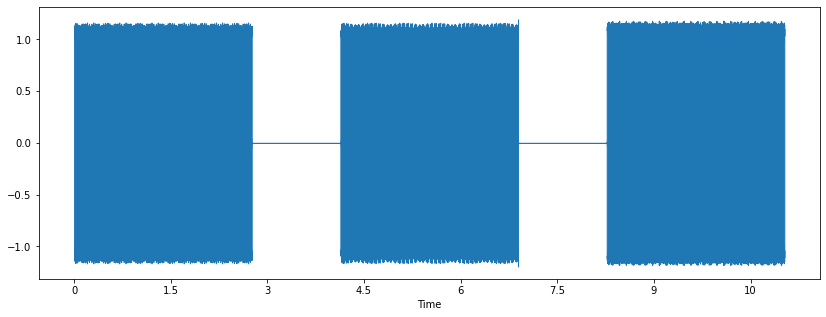

In [157]:
#dtmf.wav
dtmf, dtmf_sr = librosa.core.load("resources/dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

In [167]:
# YOUR CODE HERE
#кусочки сигнала на цифрах 1 2 и 3

# обрезаные прямоугольным окном цифры 
digit_one = dtmf[:2*dtmf_sr]
digit_two = dtmf[int(4.5*dtmf_sr) : int(6.5*dtmf_sr)]
digit_three = dtmf[int(8.5*dtmf_sr) :int(10.5*dtmf_sr)]

# цифры в спектральной форме
spec_digit_one = scipy.fft.fft(digit_one)
spec_digit_two = scipy.fft.fft(digit_two)
spec_digit_three = scipy.fft.fft(digit_three)

# обрезаем что бы на графиказ смотрелось
spec_digit_one_cut = spec_digit_one[:10000]
spec_digit_two_cut = spec_digit_two[:10000]
spec_digit_three_cut = spec_digit_three[:10000]

In [177]:
len(dtmf[:2*dtmf_sr])

44100

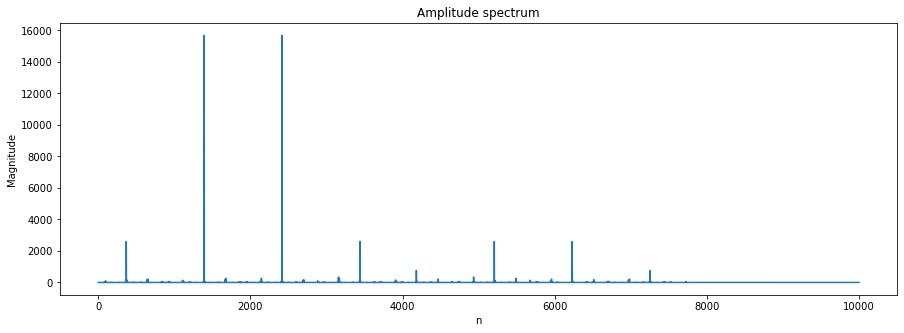

In [168]:
draw_spec(spec_digit_one_cut, draw_p=False, figsize=(15,5))

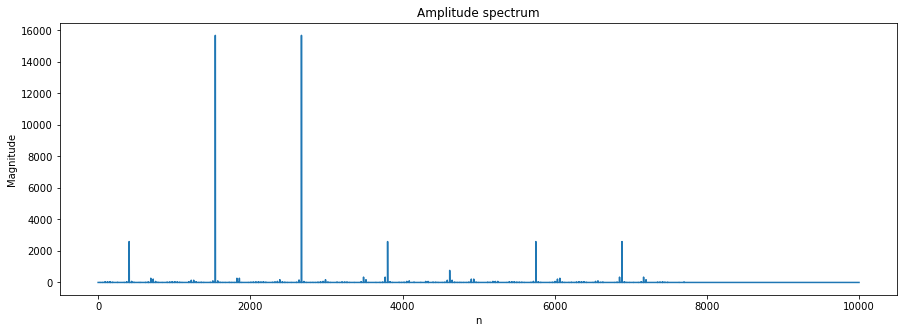

In [169]:
draw_spec(spec_digit_two_cut, draw_p=False, figsize=(15,5))

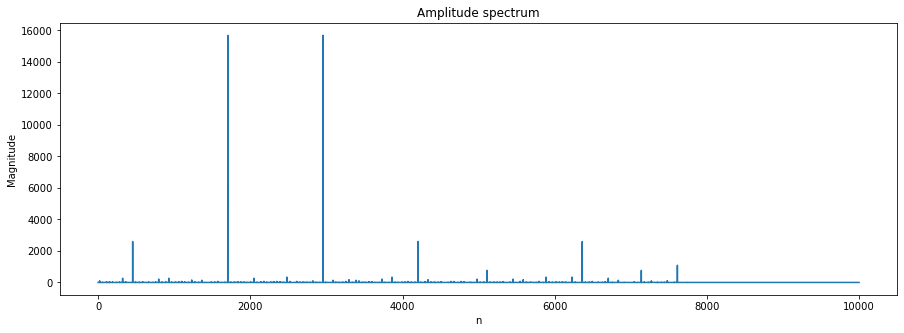

In [170]:
draw_spec(spec_digit_three_cut, draw_p=False, figsize=(15,5))

### 1 число

In [195]:
# YOUR CODE HERE
k11 = np.argmax(abs(spec_digit_one[:2000]))

k12 = np.argmax(abs(spec_digit_one[2000:4000]))
k12 = k12 + 2000

f1 = (22050 / 44100) * k11 
f2 = (22050 / 44100) * k12 

print(f"f1: {f1}, f2: {f2}")

f1: 697.0, f2: 1209.0


По табличке видо, что число с такими частотами = 1

### 2 число

In [196]:
# YOUR CODE HERE
k11 = np.argmax(abs(spec_digit_two[:2000]))

k12 = np.argmax(abs(spec_digit_two[2000:4000]))
k12 = k12 + 2000

f1 = (22050 / 44100) * k11 
f2 = (22050 / 44100) * k12 

print(f"f1: {f1}, f2: {f2}")

f1: 770.0, f2: 1336.0


Это число = 5 

### 3 число

In [197]:
# YOUR CODE HERE
k11 = np.argmax(abs(spec_digit_three[:2000]))

k12 = np.argmax(abs(spec_digit_three[2000:4000]))
k12 = k12 + 2000

f1 = (22050 / 44100) * k11 
f2 = (22050 / 44100) * k12 

print(f"f1: {f1}, f2: {f2}")

f1: 852.0, f2: 1477.0


Это число = 9 

### Тест

In [198]:
# phone_number = [first: int, second: int, third: int]
phone_number = [1, 5, 9]

In [199]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")   

Correct!
